# Make CIGALE test input from VIDEO SXDS data

This notebook uses the HELP python environment to make a CIGALE input catalogue:

https://github.com/H-E-L-P/herschelhelp_internal

to make the CIGALE inputs we must correct for galactic extinction, convert flux measurements from nano-Janksy to milli-Jansky, merge in the spectroscopic redshifts.

This is an early test on the catalogues as part of our validation process.

In [1]:

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
from herschelhelp.filters import correct_galactic_extinction
from herschelhelp.external import convert_table_for_cigale
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

import numpy as np
import os
import time

from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3

In [2]:
SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))

In [3]:
SUFFIX

'20210906'

In [4]:
hsc_bands = 'GRIZY'
vista_bands = 'ZYJHK'
bands = ['HSC_{}'.format(b) for b in hsc_bands]
bands += ['VISTA_{}'.format(b) for b in vista_bands]
cols = ['id', 'VISTA_Ks_m_coord_ra','VISTA_Ks_m_coord_dec','VISTA_Ks_m_detect_isPrimary']
cols+=['{}_m_slot_ModelFlux_flux'.format(b.replace('K','Ks')) for b in bands]
cols+=['{}_m_slot_ModelFlux_fluxErr'.format(b.replace('K','Ks'))  for b in bands]
cat = Table.read('../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS.fits')[cols]
cat['VISTA_Ks_m_coord_ra'].name='ra'
cat['VISTA_Ks_m_coord_dec'].name='dec'
#Some HELP functions require a help_id col
cat['id'].name='help_id'

In [5]:
#Rename to CIGALE/HELP format
for c in cat.colnames:
    if c.endswith('m_slot_ModelFlux_flux'):
        mask = cat[c]>1e10
        cat[c][mask]=np.nan
        f_name='f_{}_{}'.format(
            c.split('_')[0].lower().replace('hsc','suprime'),
            c.split('_')[1].lower()
        )
        cat[c].name=f_name
        cat[f_name]=cat[f_name].to(u.uJy)
    if c.endswith('m_slot_ModelFlux_fluxErr'):
        mask = cat[c]>1e10
        cat[c][mask]=np.nan
        ferr_name='ferr_{}_{}'.format(
            c.split('_')[0].lower().replace('hsc','suprime'),
            c.split('_')[1].lower()
        )
        cat[c].name=ferr_name
        cat[ferr_name]=cat[ferr_name].to(u.uJy)

In [6]:
mask = (cat['ra']<1e10) | (cat['dec']<1e10)
mask&=cat['VISTA_Ks_m_detect_isPrimary']==1
mask&=(cat['f_suprime_i']/cat['ferr_suprime_i'] > 5)
mask&=(cat['f_vista_ks']/cat['ferr_vista_ks'] > 5)
cat = cat[mask]
    
cat['ra']=cat['ra'].to(u.deg)
cat['dec']=cat['dec'].to(u.deg)

In [7]:
cat[0:5]

help_id,ra,dec,VISTA_Ks_m_detect_isPrimary,f_suprime_g,f_suprime_r,f_suprime_i,f_suprime_z,f_suprime_y,f_vista_z,f_vista_y,f_vista_j,f_vista_h,f_vista_ks,ferr_suprime_g,ferr_suprime_r,ferr_suprime_i,ferr_suprime_z,ferr_suprime_y,ferr_vista_z,ferr_vista_y,ferr_vista_j,ferr_vista_h,ferr_vista_ks
,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
149940984795367161,34.03198792407938,-5.636746033451176,1,0.1918380120633462,0.24114609138728316,0.23910295624418496,0.3943670650640425,0.539275444256114,3.3093421221815893,0.5509247061854611,0.41870752165663716,0.3170050549873974,1.4210650305132755,0.01933043244302869,0.030078245621829574,0.027566898414982985,0.0778258370449352,0.1583567806404285,0.06724782055241774,0.024002575829053612,0.023418802960395863,0.035446290741617044,0.06803846082798298
149940984795367228,34.03239043843923,-5.63513409597789,1,0.5193620245085407,0.8073257364329538,0.6775046773308321,1.1696392994439777,1.376104949778619,0.7212169913401356,1.1436669705612827,1.5161937043715057,0.7363723324967524,1.9766101985524038,0.022960893798619434,0.05553958305818498,0.03954325169680315,0.0898612977774623,0.19791099115015662,0.00928557764376431,0.018521803949740616,0.029229104310411657,0.03511634243528409,0.054673791964521476
149940984795367270,34.092669339372655,-5.634361990777769,1,0.36384861296157717,0.7892301676025678,1.2315274181560765,1.4359311773782693,1.8894775961718346,1.0766499332264072,1.0725330148649175,1.2880861811268447,2.062232090325329,1.6832976225622505,0.017392853109826446,0.02630454007725901,0.02704338733473185,0.05569826571177505,0.19013509621684996,0.0107364834608036,0.018037655838292282,0.029016609691475705,0.048036069653102864,0.06734791599744612
149940984795367288,34.107736780652246,-5.634215412521896,1,0.1386149795474109,0.05213683841882216,0.17740765789056012,0.3595270423291327,0.8112687409022378,0.2476538292474139,0.31713807754942025,0.8667135068230658,1.2445507718205489,0.9546880507128258,0.022092521907655677,0.026488851509346475,0.029234692678244106,0.057606192085304514,0.15846595810001673,0.010854198644272166,0.018258807749051895,0.03785618111103003,0.11295631819774835,0.08459614884109998
149940984795367292,33.96461795640932,-5.633879365508137,1,0.5398559354684481,0.713206483879246,0.7658640563342345,1.1315693305752763,1.535094461866041,0.5064604919459583,0.6504969996625733,1.0177887608324134,nan,1.034369760515549,0.019511755613238497,0.0456005272285144,0.030271430955299255,0.06703133567861314,0.20062454166051713,0.010458156541137244,0.01701051807225166,0.026377929025613298,nan,0.06331285964531365


In [8]:
!mkdir data
!wget http://hedam.lam.fr/HELP/dataproducts/dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.91.fits.gz -P ./data/

mkdir: data: File exists
--2021-09-06 13:38:25--  http://hedam.lam.fr/HELP/dataproducts/dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.91.fits.gz
Resolving hedam.lam.fr (hedam.lam.fr)... 195.221.212.141
Connecting to hedam.lam.fr (hedam.lam.fr)|195.221.212.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3391102 (3.2M) [application/x-gzip]
Saving to: ‘./data/XMM-LSS-specz-v2.91.fits.gz.9’

XMM-LSS-specz-v2.91 100%[===================>]   3.23M  5.61MB/s    in 0.6s    

2021-09-06 13:38:26 (5.61 MB/s) - ‘./data/XMM-LSS-specz-v2.91.fits.gz.9’ saved [3391102/3391102]



## Merge Specz

In [9]:
specz=Table.read('./data/XMM-LSS-specz-v2.91.fits.gz')
for c in specz.colnames:
    specz[c].name=c.lower()
specz['objid'].name='specz_id'

In [10]:
len(specz)

127682

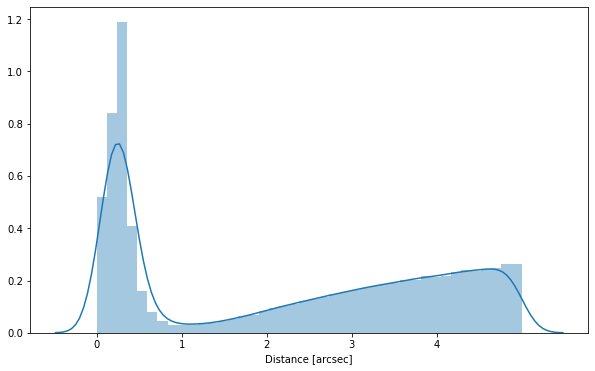

In [11]:
nb_merge_dist_plot(
    SkyCoord(cat['ra'], cat['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [12]:
cat = specz_merge(cat, specz, radius=1. * u.arcsec)

In [13]:
cat=cat[cat['specz_id']!='']

In [14]:
cat['redshift']=cat['zspec']

In [15]:
len(cat)

83687

In [16]:
cat[0:5]

help_id,ra,dec,VISTA_Ks_m_detect_isPrimary,f_suprime_g,f_suprime_r,f_suprime_i,f_suprime_z,f_suprime_y,f_vista_z,f_vista_y,f_vista_j,f_vista_h,f_vista_ks,ferr_suprime_g,ferr_suprime_r,ferr_suprime_i,ferr_suprime_z,ferr_suprime_y,ferr_vista_z,ferr_vista_y,ferr_vista_j,ferr_vista_h,ferr_vista_ks,specz_id,zspec,zspec_qual,zspec_association_flag,redshift
,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str33,float64,int64,bool,float64
149940984795368488,34.10407025372452,-5.605978251120504,1,0.34723895518347586,1.3840965971098,3.9475580319571364,6.025872568788343,6.975954853809888,5.983723849711964,6.675733786120917,10.721057893784982,14.98851788474913,18.405063522879285,0.017079866914470943,0.029173640006174003,0.03066456777209846,0.06388906821369413,0.16999562415197259,0.011375732332700046,0.01812977345981327,0.029668155255377117,0.04940991001460621,0.06957982257254518,VIPERS-105217258,0.6381,4,False,0.6381
149940984795369896,34.03893298344629,-5.571325213602774,1,2.2021062818504467,2.8041652666715726,3.5174863865610306,5.526770264870579,6.770216848940957,3.804265082589713,4.590691597626179,5.793308461435549,8.10252777223114,8.973638516449446,0.031022190625259245,0.055287615142117455,0.06814548605888027,0.15140730599479107,0.317848329753599,0.014083530133696762,0.019421278083787123,0.03644891667642288,0.06227872095955973,0.08572107358215024,VIPERS-114013662,1.3838,2,False,1.3838
149940984795384280,34.07550074924483,-5.63786147015687,1,7.908911855784077,37.724888903945974,71.32971427834585,99.74206019180589,117.40106197113136,61.06424558897672,87.27580447200684,132.73155447859673,196.13805315489753,247.99742952619835,0.04336680535575246,0.07633462747352954,0.06154238812315937,0.11829435786263728,0.2562789379547039,0.01631740354432525,0.02660168944989076,0.037652646404786064,0.06915811945471749,0.1048592132537531,OzDES_001924,0.41443,4,False,0.41443
149940984795384292,34.11936529228525,-5.640340119641305,1,4.055106681849048,10.153298519473163,27.712999267158203,40.73576718298628,55.56889384470375,nan,nan,38.85576229544384,nan,75.835338283525,0.05970076247366647,0.057817778655414764,0.047464833136954,0.09978751602416282,0.24092955651370862,nan,nan,0.06695707503320905,nan,0.1851097861005107,VIPERS-105209717,0.7046,5,False,0.7046
149940984795384296,34.05322981757711,-5.627701179292539,1,3.0493001722782167,6.750550582274663,9.827000670781645,12.393846109540867,21.746535343817182,9.486476727247677,12.851044609859064,18.581404448347776,25.700209515855086,28.660933057947968,0.018789770737188287,0.034602460221046696,0.03179320131099759,0.0710747402489922,0.18186859704618394,0.01058423994539642,0.017349735800718302,0.02926319464407901,0.04940178362927275,0.06864640159051165,SDSS 1237679321787138765,0.4584428,4,False,0.4584428


## Add EBV column

This is used to correct for galactic extinction.

In [17]:
cat.add_column(
    ebv(cat['ra'], cat['dec'])
)

## Convert to CIGALE and write catalogue

In [18]:
# Correction for galactic extinction
best_catalogue = correct_galactic_extinction(cat, inplace=True)
# Convertion to CIGALE format
best_catalogue = convert_table_for_cigale(best_catalogue, inplace=True, remove_zerofluxes=True)

In [19]:
best_catalogue[0:5]

id,ra,dec,ebv,redshift,suprime_g,suprime_g_err,suprime_r,suprime_r_err,suprime_i,suprime_i_err,vista_z,vista_z_err,suprime_z,suprime_z_err,suprime_y,suprime_y_err,vista_y,vista_y_err,vista_j,vista_j_err,vista_h,vista_h_err,vista_ks,vista_ks_err
,deg,deg,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
149940984795368488,34.10407025372452,-5.605978251120504,0.019408485287841733,0.6381,0.0003707103401241331,1.8234369095463047e-05,0.0014492702502430339,3.054735387727702e-05,0.0040795585295098115,3.1689945529787287e-05,0.00614249646057396,1.1677576931196508e-05,0.006181673600107129,6.554094229567316e-05,0.007128869396925194,0.00017372196753342423,0.006811587734607005,1.849872186137994e-05,0.010874506057748394,3.0092789092561986e-05,0.015127951678390143,4.986955594155991e-05,0.018521238977526833,7.001902059604628e-05
149940984795369896,34.03893298344629,-5.571325213602774,0.01935036037226215,1.3838,0.0023504957120446704,3.3112627961640014e-05,0.002935801829130571,5.788299412721663e-05,0.0036347478684042043,7.041723349384336e-05,0.003904901490083189,1.4456089838846577e-05,0.005669233414295567,0.00015531012095257475,0.006918172300662536,0.00032479454643423596,0.004683831470995584,1.9815313566878886e-05,0.005875976733322391,3.696902862520745e-05,0.008177676436429351,6.285633856478707e-05,0.009030111268119673,8.626053200722899e-05
149940984795384280,34.07550074924483,-5.63786147015687,0.018948701557299608,0.41443,0.008430436372969434,4.6226472100993716e-05,0.03945822569863658,7.984195704700455e-05,0.07365745832959542,6.355073666769944e-05,0.06264565221890002,1.673998225465305e-05,0.10225906859798124,0.00012127953675879002,0.1199129080703559,0.0002617621358049348,0.08900941266288202,2.713009370809775e-05,0.13458599441743818,3.8178704971420046e-05,0.19791924755087797,6.978616716309361e-05,0.24952562760764904,0.00010550537175960117
149940984795384292,34.11936529228525,-5.640340119641305,0.019494952102083473,0.7046,0.004330470615423,6.37547709330979e-05,0.010633571554853827,6.055268495217597e-05,0.028643877981386446,4.90591752872079e-05,nan,nan,0.04179375730946512,0.00010237919930399822,0.056792462842597966,0.00024623457368483365,nan,nan,0.039414391709676706,6.79197171072505e-05,nan,nan,0.07631616136994657,0.0001862834481516632
149940984795384296,34.05322981757711,-5.627701179292539,0.018787766424658486,0.4584428,0.0032486128155618348,2.001793413886617e-05,0.007058023176420897,3.6178525473552676e-05,0.01014492362369567,3.2821774400794524e-05,0.009730038904305172,1.0855986832857301e-05,0.012703917698155636,7.285290155780674e-05,0.022207818496026925,0.00018572635730118835,0.013104122860695391,1.7691407697612162e-05,0.018838791785484567,2.9668544829878598e-05,0.025931610457753225,4.984659009111149e-05,0.028836041526832543,6.906580755516208e-05


In [21]:
best_catalogue.write('./data/lsst_ir_fusion_sxds_specz_cigale_input_{}.fits'.format(SUFFIX),overwrite=True)

In [27]:
try:
    cat['ebv'].to(u.mJy)
except 'UnitConversionError':
    print('asdf')

TypeError: catching classes that do not inherit from BaseException is not allowed